# Prediciting music genres 
The goal of this project is to create a supervised learning algorithm which predicts the genre of a given song which belongs to one of the following categories: 
* Techno
* Hip-Hop
* Classical
* Pop
* Jazz
* Soul
* Rock'n roll

The data will be gathered using the Spotify API. After authenticating, I will be getting a list of ```track_ids``` from the different playlists corresponding to each genre. Then, with another ```GET``` request, I will extract the ```features``` for each track and store them into a pandas DataFrame. 

Spotify provides several interesting features for a given track which will be used to build the model: 
* danceability        
* energy
* loudness            
* speechiness         
* acousticness        
* instrumentalness    
* liveness            
* valence: the higher this value is, the more 'positive' the track sounds.           
* tempo                   

In [1]:
import pandas as pd 
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
%matplotlib inline 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [2]:
#Getting the bearer token
client_id = '298caf1fc6b3446e9063d5d0c8a43035'
client_secret = '8caba963b62449d78cd4d19bb0171f10'
response = requests.post('https://accounts.spotify.com/api/token', data = {'grant_type': 'client_credentials', 'client_id': client_id, 'client_secret': client_secret})
auth_response_data = response.json()
access_token = auth_response_data['access_token']
headers = {'Authorization': 'Bearer ' + access_token}

In [3]:

def getTrackID(genre_urls):
    
    '''This function creates an array which stores lists of all the track ids for each playlist for each genre
    it's argument is a list of url extensions''' 
    
    # base URL of all Spotify API endpoints
    base_URL = 'https://api.spotify.com/v1/playlists/'
    
    genre_ids=[]
    for genre_url in genre_urls:
    

        genre_id = []
        url = base_URL + genre_url
        songs = requests.get(url, headers = headers).json()
        for song in songs['items']: 
            genre_id.append(song['track']['id'])
        
        genre_ids.append(genre_id)
    
    return genre_ids

    

In [4]:
#url extensions for each genre. 
genre_urls = {'tech': '2MSE9BQC2U1i3U4NNltxOw/tracks', 'hip': '482XK9cqY3NjMiLZN2aXNt/tracks', 'classical': '1h0CEZCm6IbFTbxThn6Xcs/tracks',
             'pop': '37i9dQZF1DWXti3N4Wp5xy/tracks', 'jazz': '37i9dQZF1DXbITWG1ZJKYt/tracks', 'soul': '73sIU7MIIIrSh664eygyjm/tracks',
             'rock': '37i9dQZF1DWXRqgorJj26U/tracks'}


#now we get our array containing all track ids for each genre. 
genre_ids = getTrackID(list(genre_urls.values()))


In [5]:
for i in range(len(genre_ids)):
    print(list(genre_urls.keys())[i]  + ': ' + str(len(genre_ids[i])) + ' tracks')

tech: 100 tracks
hip: 100 tracks
classical: 100 tracks
pop: 100 tracks
jazz: 100 tracks
soul: 100 tracks
rock: 100 tracks


We see that we will have around 100 tracks for each genre in our dataframe. This means our dataset will be balanced, which will help for model building. 

In [6]:
#getting track features and storing them into a dataframe


#this is the label of the genre it needs to be a number that we can feed into our machine learning algorithm
target = [j for j in range(7)]   
    
genre_dfs = []
url = 'https://api.spotify.com/v1/audio-features?ids={}'
    
for genre_id in genre_ids:

    indx = genre_ids.index(genre_id)    
    genre_id = ','.join(genre_id)
    r = requests.get(url.format(genre_id), headers = headers)
    genre_df = pd.DataFrame(r.json()['audio_features'])
    
    genre_df['target'] = target[indx]
    genre_dfs.append(genre_df)
        
df = pd.concat(genre_dfs)
df



,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,target
0,0.760,0.964,2,-5.844,1,0.0577,0.00181,0.703000,0.0975,0.643,125.003,audio_features,6ho0GyrWZN3mhi9zVRW7xi,spotify:track:6ho0GyrWZN3mhi9zVRW7xi,https://api.spotify.com/v1/tracks/6ho0GyrWZN3m...,https://api.spotify.com/v1/audio-analysis/6ho0...,248036,4,0
1,0.771,0.731,7,-6.574,1,0.0409,0.00165,0.633000,0.2170,0.635,123.026,audio_features,5lXY6PTuWXOludKy4zDQwM,spotify:track:5lXY6PTuWXOludKy4zDQwM,https://api.spotify.com/v1/tracks/5lXY6PTuWXOl...,https://api.spotify.com/v1/audio-analysis/5lXY...,189268,4,0
2,0.930,0.483,3,-9.925,1,0.0411,0.02890,0.002440,0.1030,0.570,120.022,audio_features,1a8tAQAzHIPQ00OPBXGWPz,spotify:track:1a8tAQAzHIPQ00OPBXGWPz,https://api.spotify.com/v1/tracks/1a8tAQAzHIPQ...,https://api.spotify.com/v1/audio-analysis/1a8t...,204992,4,0
3,0.872,0.663,9,-8.834,1,0.0759,0.00389,0.072500,0.8340,0.304,126.019,audio_features,1tRLXy4R5YDnwATpNIkz1R,spotify:track:1tRLXy4R5YDnwATpNIkz1R,https://api.spotify.com/v1/tracks/1tRLXy4R5YDn...,https://api.spotify.com/v1/audio-analysis/1tRL...,245714,4,0
4,0.707,0.881,10,-7.295,0,0.0525,0.00572,0.001510,0.3530,0.854,120.000,audio_features,3nOMGGeQppHhfrkQ65VLVQ,spotify:track:3nOMGGeQppHhfrkQ65VLVQ,https://api.spotify.com/v1/tracks/3nOMGGeQppHh...,https://api.spotify.com/v1/audio-analysis/3nOM...,340268,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.700,0.686,9,-10.338,0,0.0279,0.09430,0.000002,0.0847,0.815,125.412,audio_features,4d9RTWdrFLVAGhdzvqxkwn,spotify:track:4d9RTWdrFLVAGhdzvqxkwn,https://api.spotify.com/v1/tracks/4d9RTWdrFLVA...,https://api.spotify.com/v1/audio-analysis/4d9R...,268933,4,6
96,0.280,0.908,2,-5.509,0,0.1090,0.03270,0.000009,0.1800,0.260,118.698,audio_features,5XcZRgJv3zMhTqCyESjQrF,spotify:track:5XcZRgJv3zMhTqCyESjQrF,https://api.spotify.com/v1/tracks/5XcZRgJv3zMh...,https://api.spotify.com/v1/audio-analysis/5XcZ...,270080,4,6
97,0.619,0.579,4,-9.307,1,0.0473,0.01520,0.000064,0.0858,0.690,127.224,audio_features,4alHo6RGd0D3OUbTPExTHN,spotify:track:4alHo6RGd0D3OUbTPExTHN,https://api.spotify.com/v1/tracks/4alHo6RGd0D3...,https://api.spotify.com/v1/audio-analysis/4alH...,225627,4,6
98,0.729,0.989,9,-4.613,0,0.0490,0.01020,0.000044,0.4430,0.840,126.470,audio_features,51H2y6YrNNXcy3dfc3qSbA,spotify:track:51H2y6YrNNXcy3dfc3qSbA,https://api.spotify.com/v1/tracks/51H2y6YrNNXc...,https://api.spotify.com/v1/audio-analysis/51H2...,352906,4,6


We immediately set the ```target``` to a number: 0 for techno, 1 for hip-hop, 2 for classical, 3 for pop, 4 for jazz, 5 for soul and 6 for rock. This is because the classifier can only work with numerical data.  

## Cleaning 
I have chosen to drop the following variables. Some of these may be obvious, such as ```id```, ```uri``` and others less so.

**Mode**: this refers to whether the song is written in a major or minor [key](https://en.wikipedia.org/wiki/Key_(music)). I believe this data has little importance in determining the genre of a song becau

In [7]:
#Keep only useful columns: 
df.drop(columns = ['type', 'id', 'uri', 'track_href', 'analysis_url'], inplace= True)

#Checkning for nulls and duplicated
print(df.isnull().any())
print(df.duplicated().any())

danceability        False
energy              False
key                 False
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
duration_ms         False
time_signature      False
target              False
dtype: bool
True


Great! No missing values or duplicate data. 

## Preparing the data
In this section, we define the response variable and the different predictors. The data is scaled to 0 mean and 1 standard deviation. Here, we will assume the numerical covariates (all except ```mode``` ) are normally distributed. To scale them we will apply the following transformation:$$ Z = \frac{ X- \mu}{\sigma}$$

In [8]:
#scale
df[df.columns[:-1]] = df[df.columns[:-1]].apply(lambda x: (x-x.min())/(x.max()-x.min()))

#Shuffle rows
df=df.sample(frac=1)

#response
y = df.target

#variables
X = df.drop('target', axis =1)
#train and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)



## Quick EDA
In this section, a quick exploration of the data will be done in order to draw basic insights and see how the track features vary for each genre. 

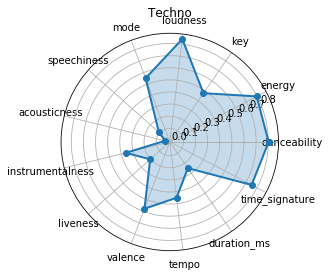

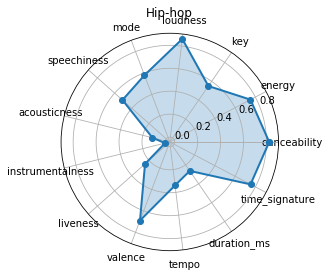

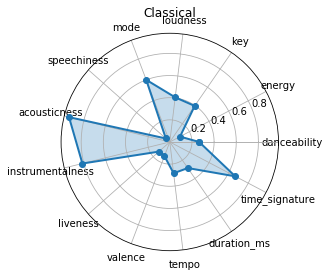

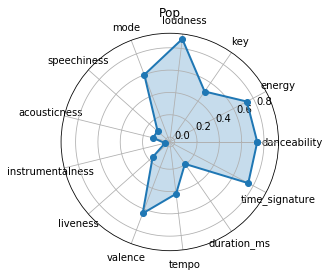

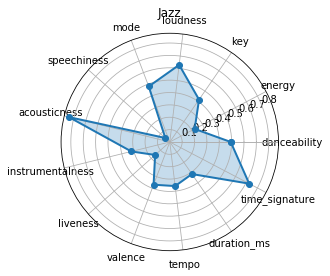

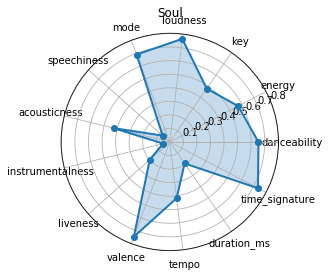

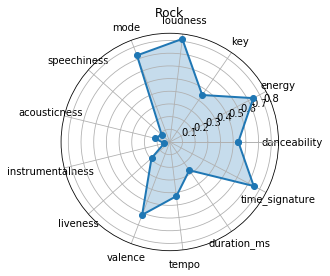

In [9]:
labels = df.columns[:-1]
genres = ['Techno', 'Hip-hop', 'Classical','Pop', 'Jazz', 'Soul', 'Rock' ]
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles=np.concatenate((angles,[angles[0]]))
stats = []
for target in range(7):
    stats.append(df[df['target']== target].mean()[:-1])
    stats2 = np.concatenate((stats[target], [stats[target][0]]))
    fig=plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats2, 'o-', linewidth=2)
    ax.fill(angles, stats2, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.grid(True)
    ax.set_title(genres[target])
    

    
    

We see that the different track features vary for each genre. Techno music louder, more energetic and has a high danceability. Hip-hop contains more vocals so has a higher speechiness. Classical music is more instrumental, quiet and acoustic. Pop is like techno but with less liveness whilst jazz is more acoustic. Soul music has more valence and danceability but is slower whereas rock is more energetic. 

## K- Nearest Neighbors algorithm

### Explanation
This a supervised clustering method which relies on the principle that *similar objects are close to one another*. An integer $k \in \mathbb N$ is picked (more on how to select $k$ later), then the distance between the object we want to classify and it's $k$ nearest neighbors is determined. 

Suppose we have a $d-1$ dimensional feature vector:$$ \mathbf X = \begin{pmatrix} x_1 \\ x_2\\ .\\.\\. \\ x_{d-1} \end{pmatrix} \in \mathbb R^{d-1}$$

We then denote the set of it's $k$ nearest neighbors as $S$. This set is defined in the following way: 
$S \subseteq \mathbb R^d$ such that  $|S| = k$ and $\forall  (\mathbf X^{\prime}, y^{\prime}) \in \mathbb R^d \setminus \{S \}$: $$ \left( \sum_{i=1}^{d-1} |x_i - x^{\prime}_i|^p \right) ^{1/p} \geq \sup_{(\mathbf X^{\prime \prime}, y^{\prime \prime}) \in S} \left( \sum_{i=1}^{d-1} |x_i - x^{\prime \prime}_i|^p \right) ^{1/p},  p \in \mathbb N$$

Where $y$ represents the class of the corresponding feature vector. This distance formula is quite general and is known as the Minkowski distance. The most commonly used distance function is the Euclidean distance, where $p=2$.

 We can then define the classifier $c(\mathbf X)$ in the following way: $$c: \mathbb R^{d-1} \to \mathbb N, c(\mathbf X) = \DeclareMathOperator{\mode}{mode} \mode \{ y^{\prime \prime} , (\mathbf X^{\prime \prime}, y^{\prime \prime}) \in S \}$$
 

This classifier takes the *mode* of $y \in S$ IE, the majority class present in the k-nearest neighbors of $\mathbf X$. 


### Building our own $k$-NN algorithm



In [10]:
def Dist(x,z):
    return np.sqrt((x-z)**2)

### Determining the optimal value of $k$
There are several ways to find an optimal value of $k$. We could use the *elbow method* to find a value of $k$ which maximizes the accuracy. The elbow method is commonly used in clustering techniques. We will repeatedly take random samples of our data and each time fit a KNN model to it with a particular value of $k$. 



In [11]:
accuracy = []

for k in range(1,40):
    
    model = KNeighborsClassifier(n_neighbors=k)
    score=cross_val_score(model, X, y, cv=10)
    accuracy.append(score.mean())

Text(0, 0.5, 'Accuracy')

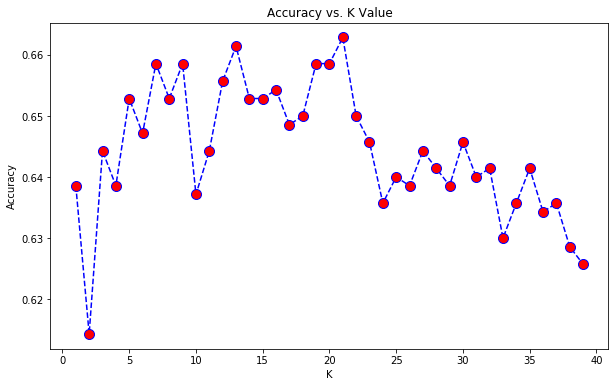

In [12]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),accuracy,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')

We see our model is most accurate for $5 \leq k \leq 10$. Beyond these bounds, the accuracy decays. 

In [13]:
model1 = KNeighborsClassifier(n_neighbors = 9)
model1.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [14]:
y_pred = model1.predict(X_test)

In [15]:
accuracy_score = model1.score(X_test, y_test) 
print("Accuracy score = ""{:.2f}".format(accuracy_score))

Accuracy score = 0.71


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65        22
           1       0.86      0.95      0.90        19
           2       0.96      0.96      0.96        28
           3       0.44      0.78      0.56        18
           4       0.78      0.88      0.82        16
           5       0.69      0.45      0.55        20
           6       0.57      0.24      0.33        17

    accuracy                           0.71       140
   macro avg       0.71      0.70      0.68       140
weighted avg       0.73      0.71      0.70       140



**Precision:** $ \frac {TP}{TP+FP}$

**Recall:** $ \frac  {TP}{TP+FP}$ 

**f1-score** $\frac{TP}{TP+ \tfrac12 (FP+FN)}$

**Accuracy:** $\frac{ TP+ TN}{TP+TN+FP+FN}$

We see our model was very good at identifying classical music as well as jazz. Looking back at the radar plots, we see that these genres have particular features which can help differentiate them from the rest. Indeed, classical music is particulary acoustic and instrumental. Likewise, jazz is highly acoustic but has a lower instrumentalness. 

On the other hand, the model struggled to identify soul and pop songs. Indeed this genres have the lowest precision recall and f1-scores associated. Overall, our KNN model outputs an accuracy of 73%, which is quite good given the fact that we have high dimensional data (9D) and 7 different genres to classify. 

## Model Improvements 

### Curse of dimensionality 
One reason why the model might not be performing as well as one would expect is because there are too many input features. The main assumption required for a k-NN classifier is that similar objects are *close to one another*. As it turns out, as the number of dimensions in our model increases this assumption breaks. We can try using PCA (principal component analysis) to reduce the dimensionality of our input. 

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(0.9) #retain the components that 'explain' 90% of the variance 
X_pca = pca.fit_transform(X)
X_pca.shape

(700, 7)

In [19]:
X1_train, X1_test,y_train, y_test = train_test_split(X_pca,y,test_size=0.2,random_state=0)

In [20]:
model2 = KNeighborsClassifier(n_neighbors = 9)
model2.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [21]:
model2.score(X_test, y_test)

0.7142857142857143

In [22]:
print(classification_report(y_test, model2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.64      0.65        22
           1       0.86      0.95      0.90        19
           2       0.96      0.96      0.96        28
           3       0.44      0.78      0.56        18
           4       0.78      0.88      0.82        16
           5       0.69      0.45      0.55        20
           6       0.57      0.24      0.33        17

    accuracy                           0.71       140
   macro avg       0.71      0.70      0.68       140
weighted avg       0.73      0.71      0.70       140

